In [2]:
import pandas as pd
import xarray as xr
import numpy as np
import scipy.stats as stats
import requests
import rasterio
from rasterio.plot import show
import richdem as rd
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import train_test_split
from scipy.stats import poisson
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pingouin as pg
from rasterio.plot import show
import matplotlib.pyplot as plt
from matplotlib.colors import LightSource
import math

In [3]:
aval_2025 = pd.read_csv('../Data/avalanche-record-CAIC3.csv')
aval_2025['Date'] = aval_2025['Date'].str.split(' GMT').str[0]
aval_2025['Date'] = pd.to_datetime(aval_2025['Date'])
aval_2025['Date'] = aval_2025['Date'].dt.strftime('%b %d')
aval_2025 = aval_2025.loc[:, ["Date", "Longitude", "latitude", "Type"]]
aval_2025
avalanche_date = aval_2025[aval_2025['Date'] == 'Feb 25']
for i in range(len(aval_2025)):
    if (aval_2025['Longitude'][i] == ' -'):
        aval_2025 = aval_2025.drop(i)
    elif ((float(aval_2025['Longitude'][i]) < -111.5 or float(aval_2025['Longitude'][i]) > -100.5) or (float(aval_2025['latitude'][i]) < 35.5 or float(aval_2025['latitude'][i]) > 42.5)):
        aval_2025 = aval_2025.drop(i)
aval_2025

,Date,Longitude,latitude,Type
0,Apr 30,-106.8257519,39.0440469,WL
1,Apr 30,-106.8257519,39.0440469,WL
2,Apr 29,-105.670764,40.3059332,WL
3,Apr 29,-105.671279,40.3072044,WL
4,Apr 28,-105.6861706,40.2943519,WL
...,...,...,...,...
3092,Nov 06,-107.6064493,37.7908305,SS
3093,Nov 05,-107.1211267,38.9072657,SS
3094,Nov 05,-107.1211267,38.9072657,SS
3095,Nov 05,-107.0376817,39.00537,SS


In [20]:
aval_2025['Date'] = pd.to_datetime(aval_2025['Date'], format='%b %d')

current_year = pd.Timestamp('now').year
def assign_year(dt):
    if dt.month >= 11 and dt.day:
        return dt.replace(year=2024)
    else:
        return dt.replace(year=2025)

aval_2025['Date'] = aval_2025['Date'].apply(assign_year)

# Group the DataFrame by week
weekly_groups = aval_2025.groupby(pd.Grouper(key='Date', freq='W'))

idk = []
# Iterate through the weekly groups
for week, group in weekly_groups:
    print(f"--- Week of {week.strftime('%Y-%m-%d')} ---")
    group['DayOfWeek'] = group["Date"].dt.day_name()
    day_counts = group['DayOfWeek'].value_counts().sort_index()
    idk.append(day_counts)

    # You can now perform operations on the 'group' DataFrame for each week


--- Week of 2024-11-10 ---
--- Week of 2024-11-17 ---
--- Week of 2024-11-24 ---
--- Week of 2024-12-01 ---
--- Week of 2024-12-08 ---
--- Week of 2024-12-15 ---
--- Week of 2024-12-22 ---
--- Week of 2024-12-29 ---
--- Week of 2025-01-05 ---
--- Week of 2025-01-12 ---
--- Week of 2025-01-19 ---
--- Week of 2025-01-26 ---
--- Week of 2025-02-02 ---
--- Week of 2025-02-09 ---
--- Week of 2025-02-16 ---
--- Week of 2025-02-23 ---
--- Week of 2025-03-02 ---
--- Week of 2025-03-09 ---
--- Week of 2025-03-16 ---
--- Week of 2025-03-23 ---
--- Week of 2025-03-30 ---
--- Week of 2025-04-06 ---
--- Week of 2025-04-13 ---
--- Week of 2025-04-20 ---
--- Week of 2025-04-27 ---
--- Week of 2025-05-04 ---


/var/folders/pr/qz3c0jc146355ryds4n93wjm0000gn/T/ipykernel_80789/4185690247.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['DayOfWeek'] = group["Date"].dt.day_name()
/var/folders/pr/qz3c0jc146355ryds4n93wjm0000gn/T/ipykernel_80789/4185690247.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['DayOfWeek'] = group["Date"].dt.day_name()
/var/folders/pr/qz3c0jc146355ryds4n93wjm0000gn/T/ipykernel_80789/4185690247.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

In [34]:
idk


[DayOfWeek
 Friday       1
 Saturday     9
 Sunday       6
 Thursday     4
 Tuesday      4
 Wednesday    2
 Name: count, dtype: int64,
 DayOfWeek
 Friday       16
 Saturday      1
 Sunday        2
 Thursday      6
 Tuesday       5
 Wednesday     3
 Name: count, dtype: int64,
 DayOfWeek
 Friday        2
 Saturday      3
 Thursday      1
 Tuesday      13
 Wednesday     5
 Name: count, dtype: int64,
 DayOfWeek
 Friday         9
 Monday         5
 Saturday      11
 Sunday         7
 Thursday      22
 Tuesday      266
 Wednesday    179
 Name: count, dtype: int64,
 DayOfWeek
 Friday       1
 Monday       6
 Saturday     1
 Tuesday      5
 Wednesday    1
 Name: count, dtype: int64,
 DayOfWeek
 Friday        6
 Monday        9
 Saturday     10
 Sunday       12
 Thursday      3
 Tuesday      15
 Wednesday     5
 Name: count, dtype: int64,
 DayOfWeek
 Friday        8
 Monday        5
 Saturday      1
 Sunday        4
 Thursday      6
 Tuesday       2
 Wednesday    12
 Name: count, dtype: int64,


In [35]:
total_counts = idk[0]
for i in range(len(idk) - 1):
    total_counts = total_counts.add(idk[i + 1], fill_value=0).sort_index()
total_counts
#total_day_counts = day_counts1.add(day_counts2, fill_value=0).sort_index()

DayOfWeek
Friday       381.0
Monday       343.0
Saturday     488.0
Sunday       431.0
Thursday     332.0
Tuesday      649.0
Wednesday    425.0
Name: count, dtype: float64

In [5]:
aval_2025

,Date,Longitude,latitude,Type
0,2025-04-30,-106.8257519,39.0440469,WL
1,2025-04-30,-106.8257519,39.0440469,WL
2,2025-04-29,-105.670764,40.3059332,WL
3,2025-04-29,-105.671279,40.3072044,WL
4,2025-04-28,-105.6861706,40.2943519,WL
...,...,...,...,...
3092,2024-11-06,-107.6064493,37.7908305,SS
3093,2024-11-05,-107.1211267,38.9072657,SS
3094,2024-11-05,-107.1211267,38.9072657,SS
3095,2024-11-05,-107.0376817,39.00537,SS


In [6]:
count_by_type = []
#week_ints = []
for aval_type in [' SS', ' WL', ' U', ' WS', ' L', ' HS', ' G', ' C']:
    counts = []
    counts.append((aval_2025["Type"] == aval_type).sum())
    count_by_type.append(counts)

count_by_type

[[np.int64(1802)],
 [np.int64(318)],
 [np.int64(49)],
 [np.int64(67)],
 [np.int64(119)],
 [np.int64(318)],
 [np.int64(3)],
 [np.int64(22)]]

<BarContainer object of 7 artists>

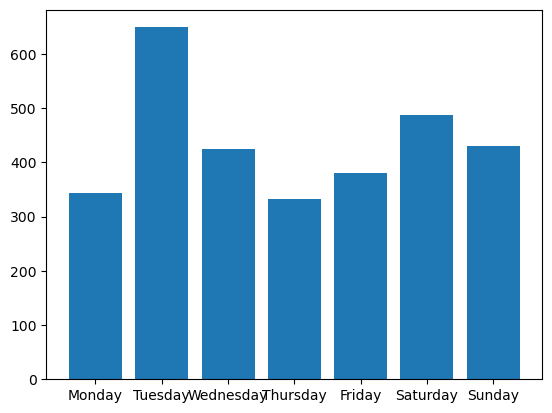

In [36]:
plt.bar(["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"], [343, 649, 425, 332, 381, 488, 431])